# 3. TensorFlow Datasets

Up till now we've used dummy datasets which can all be fit into memory. This, however, isn't feasible in very large datasets. In these cases we have our data stored in disk and load them into memory batch-by-batch before the model consumes them. The process of loading data into memory and possibly doing some preprocessing on them is done by a **data generator**.

The best choice of a data generator we can have in TensorFlow is [`tf.data.Dataset()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). This is a very optimized and flexible data generator that can help us load any kinds of data (images, text, tabular, etc.), either from memory or from the disk. Through this we will control the whole **input pipeline** of our model.

We'll see a few examples of how we can use this generator along with a few practical tips.

In [1]:
import tensorflow as tf
assert tf.__version__[0] == '2', 'this tutorial is for tensorflow versions of 2 or higher'

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

2023-04-20 18:30:12.293449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 18:30:12.436319: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-20 18:30:12.436339: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-20 18:30:13.281953: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## `tf.data.Dataset()` API

First, a simple example where we will create a generator from a numpy array of data. While this won't show the full potential of the generator as it won't require loading data from disk or preprocessing them in any way, it will give us a better understanding of the `tf.data.Dataset()` API.

Before beginning it is imporant to note that there are two ways we can create a TF dataset:
- From a **data source**. E.g. a numpy array
- By **transforming another dataset**. 

### Initialize a generator from tensors using `from_tensor_slices()`

To start playing with the API, we'll need to initialize our first generator. This needs to be done from a data source. The most common way to do this is through the The [`tf.data.Dataset.from_tensor_slices`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) method.

This allows us to initialize a dataset from tensors (or objects that can be converted to tensors like lists and numpy arrays). The naming of this method isn't very intuitive, but the *slices* refers to the fact that the generator will **slice** the first dimension of the tensor to split it into elements, which will then form the batches. 

In [2]:
X_arr = np.arange(800).reshape((100, 8))  # make dataset with 1000 examples and 8 features
y_arr = np.repeat(np.arange(10), 10)      # make labels that can belong to one of 10 classes

print(f'{X_arr.shape=}, {y_arr.shape=}')

print(X_arr[:5])  
print(y_arr[:5])  # y_arr is [0, 0, 0, ..., 1, ..., 2, ..., 9]

gen = tf.data.Dataset.from_tensor_slices((X_arr, y_arr))  # give these two arrays as a tuple

gen

X_arr.shape=(100, 8), y_arr.shape=(100,)
[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]]
[0 0 0 0 0]


2023-04-20 18:30:14.633873: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-20 18:30:14.633910: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-20 18:30:14.633929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (home): /proc/driver/nvidia/version does not exist
2023-04-20 18:30:14.634171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<TensorSliceDataset element_spec=(TensorSpec(shape=(8,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

We can iterate over this generator and it will return elements. Because we created this dataset using a tuple of two arrays, when we iterate over it, it will return a tuple of two elements: one for `X` and one for `y`. 

In [3]:
it = iter(gen)

x, y = next(it)

x, y

(<tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 1, 2, 3, 4, 5, 6, 7])>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

This is nice, but what we really want is **batches**, not individual examples. 

### Transformations

To do this we need to understand the concept of transforming a `tf.data.Dataset`. Transforming a dataset is a process where we convert a dataset to another one with a **different behavior**. This is accomplished by **chaining methods** on the dataset object.

```python
dataset2 = dataset1.method()
```

In this simplified example `dataset1` is transformed into `dataset2` which has a different behavior.

### Batching

To get bathes out of our dataset, we need to transform it into one that returns batches instead of individual examples. This is done simply through the [`tf.data.Dataset.batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) method.

In [4]:
gen = gen.batch(5)  # batch size = 5

it = iter(gen)

x, y = next(it)

x, y

(<tf.Tensor: shape=(5, 8), dtype=int64, numpy=
 array([[ 0,  1,  2,  3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29, 30, 31],
        [32, 33, 34, 35, 36, 37, 38, 39]])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 0, 0])>)

One thing to note is that if the batch size doesn't perfectly divide the number of elements, we will have some batches containing **fewer elements than the batch size**; we'll see some examples of this later on. If we don't want this behavior, we can use [`tf.data.Dataset.padded_batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch).

### Elements

Another important concept is that of the dataset's *elements*. A lot of methods work on the level of a dataset element, but this can **differ** from dataset to dataset. For example, in our first dataset, the element was the individual example, while in the second the element was a batch of 5 examples.

Dataset methods are generic enough to work on any dataset, in any order. This gives these components the ability to be flexible and reusable, however it requires a deeper understanding of the underlying mechanics. 

To understand this better let's revisit the `tf.data.Dataset.batch()` method. What this method does is that it takes multiple dataset elements and it batches them together. What would happen if we were to call this method on our already batched dataset? This would essentially batch the elements of that dataset (which are already batches).

In [5]:
gen2 = gen.batch(3)  # batch size = 3 on the already batched dataset

it = iter(gen2)

x, y = next(it)

x, y

(<tf.Tensor: shape=(3, 5, 8), dtype=int64, numpy=
 array([[[  0,   1,   2,   3,   4,   5,   6,   7],
         [  8,   9,  10,  11,  12,  13,  14,  15],
         [ 16,  17,  18,  19,  20,  21,  22,  23],
         [ 24,  25,  26,  27,  28,  29,  30,  31],
         [ 32,  33,  34,  35,  36,  37,  38,  39]],
 
        [[ 40,  41,  42,  43,  44,  45,  46,  47],
         [ 48,  49,  50,  51,  52,  53,  54,  55],
         [ 56,  57,  58,  59,  60,  61,  62,  63],
         [ 64,  65,  66,  67,  68,  69,  70,  71],
         [ 72,  73,  74,  75,  76,  77,  78,  79]],
 
        [[ 80,  81,  82,  83,  84,  85,  86,  87],
         [ 88,  89,  90,  91,  92,  93,  94,  95],
         [ 96,  97,  98,  99, 100, 101, 102, 103],
         [104, 105, 106, 107, 108, 109, 110, 111],
         [112, 113, 114, 115, 116, 117, 118, 119]]])>,
 <tf.Tensor: shape=(3, 5), dtype=int64, numpy=
 array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1]])>)

Obviously calling `.batch()` twice has limited practical applications, but it shows us that we need to be careful what method we call and where!

### Repeating a dataset

Let's see what happens if we exhaust our dataset.

In [6]:
for i, (x, y) in enumerate(gen):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


As expected the generator did $100 / 5 = 20$ iterations.

The dataset works like a proper iterator and raises a `StopIteration` error, which is caught by the for loop and ends the iteration. In NN training, this would signal the end of an epoch. How would we proceed to the next epoch then? One way would be to recreate an iterator object from the generator. A better way is to use use [`tf.data.Dataset.repeat()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat).

In [7]:
gen = gen.repeat(4)  # repeat the dataset 4 times 

for i, (x, y) in enumerate(gen):
    print(i, end=', ')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 

Leaving `.repeat()` without an argument will repeat the dataset **indefinitely** (this is actually the most common case).

### Shuffling 

Usually in NN training we would want to shuffle the dataset **at the end of each epoch**. This can be accomplished by using the [`tf.data.Dataset.shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) method. 

The way this works is that we first define a `buffer_size`. The dataset will then fill a buffer with `buffer_size` elements, then randomly samples elements from this buffer.

In [8]:
gen3 = gen.shuffle(3)  # buffer size = 3 (batches)

it = iter(gen3)

x, y = next(it)

x, y

(<tf.Tensor: shape=(5, 8), dtype=int64, numpy=
 array([[ 0,  1,  2,  3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29, 30, 31],
        [32, 33, 34, 35, 36, 37, 38, 39]])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 0, 0])>)

Probably not the result we expected. Remember the concept of dataset elements? This applies here too! The buffer that the dataset defines and shuffles is on the dataset element level, i.e. the batches. This means that the previous command fills a buffer of **3 batches** and randomly samples one of them. We can confirm this by running the previous cell multiple times. A different batch will be returned, but the batch is always in order. Essentially we managed to **shuffle the batches**, not the examples.

It's time to dig a bit deeper into method chaining and the order with which we acually call these methods.

### Method chaining order

Let's start by the most important thing: **the order with which we call these methods matters**. What is the correct order of calling them? Depends on the desired effect. The goal is to not only learn the differences between them, but understand the logic so that we can create our own input pipelines.

Let's take things one step at a time. Suppose we create a simple generator with 10 elements:

```python
gen = tf.data.Dataset.from_tensor_slices(range(1, 11))
```

This object's internal representation will look like this.

![Initial dataset](https://github.com/djib2011/tensorflow-training/blob/main/figures/tf_dataset/initial_dataset.png)

Now, let's see the effect that `gen.repeat(2)` and `gen.batch(3)` have if applied individually.

![Repeat dataset](https://github.com/djib2011/tensorflow-training/blob/main/figures/tf_dataset/repeat.png)

Repeat essentially doubled the size of our dataset, by repeating it twice.

![Batch dataset](https://github.com/djib2011/tensorflow-training/blob/main/figures/tf_dataset/batch.png)

Batch grouped our elements into batches of 3.

Each of these operations transforms the dataset in a different way. If we chain these operations in different order we would get different results. `gen.repeat(2).batch(3)` essentially means that we will now perform the batching on the doubled dataset.

![Repeat-batch dataset](https://github.com/djib2011/tensorflow-training/blob/main/figures/tf_dataset/repeat_batch.png)

On the other hand, if we were to do `gen.batch(3).repeat(2)` instead, it would repeat the already batched dataset.

![Batch-repeat dataset](https://github.com/djib2011/tensorflow-training/blob/main/figures/tf_dataset/batch_repeat.png)

Let's now see the effect of shuffle, along with the previous two methods. Let's first examine `gen.shuffle(2)`

![Shuffle dataset](https://github.com/djib2011/tensorflow-training/blob/main/figures/tf_dataset/shuffle.png)

On its own, shuffle keeps a constant size buffer (of size 2 in the example) and draws randomly one element from this. Normally we would want to add a larger buffer size (ideally equal to the **number of elements** in the dataset), but here we used a smaller one to better illustrate how shuffling works. 

Now we finally get to dig a bit deeper in the example that brought us here. Let's explore the difference between 
`gen.shuffle(2).batch(3)` and `gen.batch(3).shuffle(2)`.

![Shuffle-batch dataset](https://github.com/djib2011/tensorflow-training/blob/main/figures/tf_dataset/shuffle_batch.png)

The first simply batches the already shuffled dataset.

![Batch-shuffle dataset](https://github.com/djib2011/tensorflow-training/blob/main/figures/tf_dataset/batch_shuffle.png)

First batching the dataset and then shuffling, though, has the effect of the shuffling happening on the batch level. This means that, as we saw previously, this has the effect of shuffling the batches inside the dataset, while keeping the elements inside each batch in-order.

Finally, for closure let's put all 3 together. We won't see all combinations, as the logic should be pretty clear at this point, just one example.

![Repeat-shuffle-batch dataset](https://github.com/djib2011/tensorflow-training/blob/main/figures/tf_dataset/repeat_shuffle_batch.png)

If you want to play around on your own with these 3 methods and see the effect feel free to modify the cells below.

In [9]:
# Make a function that prints the elements of a generator
printgen = lambda gen: [g.numpy() for g in gen]

# Build initial generator
gen = tf.data.Dataset.from_tensor_slices(range(1, 11))

In [10]:
printgen(gen.repeat(2).shuffle(2).batch(3))

[array([1, 3, 4], dtype=int32),
 array([2, 6, 5], dtype=int32),
 array([ 7,  9, 10], dtype=int32),
 array([8, 1, 3], dtype=int32),
 array([2, 5, 6], dtype=int32),
 array([7, 8, 4], dtype=int32),
 array([10,  9], dtype=int32)]

### Mapping

One of the most important methods is [`tf.data.Dataset.map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map). This accepts a function and applies this function to **every element in the dataset**. Why is this so important? The function that we will map across our whole dataset can do many different things, such as **loading data**, **preprocessing** or even **data augmentation**.

Let's see an example, suppose we want to randomly turn some numbers into zeros (let's say with a probability of $30\%$). 



In [11]:
def randomly_turn_num_to_zero(num):
    return num if tf.random.uniform(shape=(1,)) > 0.3 else 0

In [12]:
printgen(gen.repeat(2).map(randomly_turn_num_to_zero))

[1, 2, 3, 0, 5, 6, 0, 0, 9, 10, 0, 2, 3, 4, 0, 6, 0, 8, 9, 10]

### Other ways of creating generators from data sources

Up till now the only way we've seen to initialize TF datasets from a data source is the `from_tensor_slices` method. There are other ways do this as well, though we won't go into details:

- [`tf.data.Dataset.from_generator()`](https://www.tensorflow.org/api_docs/python/tf/data/TextLineDataset#from_generator): Consumes a **python generator** and converts it into a TF dataset.
- [`tf.data.Dataset.TFRecordDataset()`](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset): Loads **TFRecords** into a TF dataset.
- [`tf.data.Dataset.TextLineDataset()`](https://www.tensorflow.org/api_docs/python/tf/data/TextLineDataset): Loads **text files** into a TF dataset.

## Example: Image classification input pipeline 

After reviewing the main functionalities of the TF dataset API, we'll see an example where we'll create a dataset for an image classifier. 

In this example we have a lot of images stored in our disk and we want to train an image classifier. In the specific example we will follow, our goal is to train an image classifier to classify flowers into their species.

In [13]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

A common directory structure for image classification tasks is the following:

```
data_dir
   |
   |______class_1
   |         |_________img1.jpg
   |         |_________img2.jpg
   |         |
  ...       ...
   |         |_________imgN1.jpg
   |
   |_______class_2
   |         |_________img1.jpg
   |         |_________img2.jpg
  ...       ...
   |         |_________imgN2.jpg
   |
   |_______class_M
             |________img1.jpg
             |________img2.jpg
            ...
             |________imgNM.jpg
```

This is actually what is followed by the **flowers dataset** we downloaded.

In [14]:
data_dir = Path(flowers)
classes = [p.name for p in data_dir.glob('*') if p.is_dir()]

for c in classes:
    print('--- Class: {:^10} ---'.format('"' + c + '"'))
    for img in list((data_dir / c).glob('*'))[:5]:
        print(img.name)
    print('          ...')

--- Class: "dandelion" ---
18342918441_b1bb69a2fd_n.jpg
3554992110_81d8c9b0bd_m.jpg
14128835667_b6a916222c.jpg
3584414925_1e6c4b61db_n.jpg
8209318399_ae72aefdb5.jpg
          ...
--- Class: "sunflowers" ---
6199086734_b7ddc65816_m.jpg
5923085671_f81dd1cf6f.jpg
4933824130_b99839a80d.jpg
6061175433_95fdb12f32_n.jpg
3951246342_930138610b_n.jpg
          ...
--- Class:  "tulips"  ---
16055807744_000bc07afc_m.jpg
8711277462_b43df5454b_m.jpg
110147301_ad921e2828.jpg
17189456156_6fc1067831.jpg
4681062529_36186617d9.jpg
          ...
--- Class:  "roses"   ---
8394286483_69fe04cc7f.jpg
12243069253_e512464095_n.jpg
9406573080_60eab9278e_n.jpg
16424992340_c1d9eb72b4.jpg
15537825851_a80b6321d7_n.jpg
          ...
--- Class:  "daisy"   ---
6596277835_9f86da54bb.jpg
144603918_b9de002f60_m.jpg
2498632196_e47a472d5a.jpg
7749368884_1fc58c67ff_n.jpg
12585131704_0f64b17059_m.jpg
          ...


Let's also see a few images to get a better understanding of our data.

Text(0.5, 1.0, 'roses')

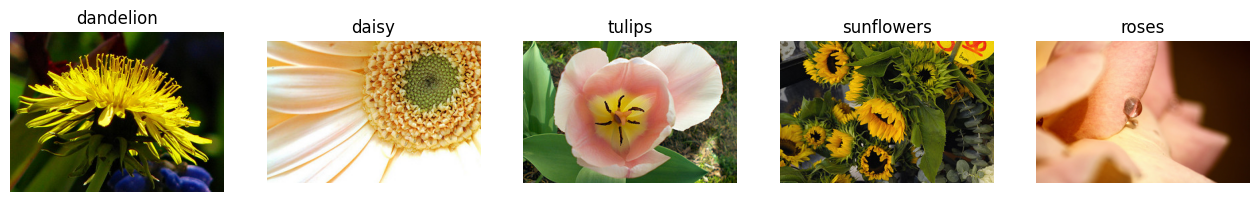

In [15]:
plt.figure(figsize=(16, 5))

ax = plt.subplot(151)
ax.imshow(plt.imread(str(data_dir / 'dandelion' / '2449852402_45d12b9875_n.jpg')))
ax.axis('off')
ax.set_title('dandelion')

ax = plt.subplot(152)
ax.imshow(plt.imread(str(data_dir / 'daisy' / '5673551_01d1ea993e_n.jpg')))
ax.axis('off')
ax.set_title('daisy')

ax = plt.subplot(153)
ax.imshow(plt.imread(str(data_dir / 'tulips' / '14266093711_66d18a1e44_n.jpg')))
ax.axis('off')
ax.set_title('tulips')

ax = plt.subplot(154)
ax.imshow(plt.imread(str(data_dir / 'sunflowers' / '3665455426_9cd1c3af4a_n.jpg')))
ax.axis('off')
ax.set_title('sunflowers')

ax = plt.subplot(155)
ax.imshow(plt.imread(str(data_dir / 'roses' / '14414123198_24606fb32d.jpg')))
ax.axis('off')
ax.set_title('roses')

Back to our task. We want to train a NN to classify flowers.

Up till our previous notebook we would load the data into a large array, i.e. `x_train` and then create another array `y_train` containing the labels. As discussed previously, in large image datasets this is infeasible, as they would take up too much memory. What we want to do instead is to define a TF dataset that **loads the images batch-by-batch**.

We need to start from somewhere, though. What we'll do is that we're going to have to generate a list of all images, along with their labels.

In [16]:
images = []
labels = []

for i, c in enumerate(classes):
    im = [str(p) for p in (data_dir / c).glob('*')]
    images += im
    labels += [i] * len(im)

labels = tf.keras.utils.to_categorical(labels, num_classes=len(classes))

print(f'{images[:5]=}\n\n{labels[:5]=}')

images[:5]=['/home/thanos/.keras/datasets/flower_photos/dandelion/18342918441_b1bb69a2fd_n.jpg', '/home/thanos/.keras/datasets/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg', '/home/thanos/.keras/datasets/flower_photos/dandelion/14128835667_b6a916222c.jpg', '/home/thanos/.keras/datasets/flower_photos/dandelion/3584414925_1e6c4b61db_n.jpg', '/home/thanos/.keras/datasets/flower_photos/dandelion/8209318399_ae72aefdb5.jpg']

labels[:5]=array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)


First, we'll initialize the TF Dataset from the list of image paths and labels.

In [17]:
ds = tf.data.Dataset.from_tensor_slices((images, labels))

Now, we need a way of loading images from their filepaths. We'll write a function that **loads an image from its path**. 

Since we initialized our dataset with both the images and the labels, this function will need to accept **two arguments** (i.e. the image path and its label) and return the loaded image and its label.

Along with actually loading the image, we'll also take the opportunity to do a couple more **preprocessing steps** like normalizing and resizing it.

In [18]:
def load_and_process_image(image_path, label, target_size=(224, 224)):
    '''
    Load an image from a path, normalize and resize it.
    '''
    img = tf.io.read_file(image_path)  # read the file
    img = tf.io.decode_jpeg(img)  # decode the bytes in the file as a jpeg image
    img = tf.image.convert_image_dtype(img, tf.float32)  # convert it from [0, 255] to [0, 1]
    img = tf.image.resize(img, target_size)  # resize it to the target size
    return img, label

Now, we need to tell the dataset to *map* this function to each element. Note that this operation won't be done now; **this will be done lazily, once each batch is loaded**.

In [19]:
ds = ds.map(load_and_process_image)

What else do we need? A way to shuffle the dataset, a way to reapeat it once its ended and a way to load batches one at a time.

In [20]:
# Shuffle the dataset
ds = ds.shuffle(buffer_size=50000)

# Repeat it indefinitely
ds = ds.repeat()

# Data will be iterated in batches of 32 images
ds = ds.batch(32)

In [21]:
for x, y in ds:
    break
    
print(f'{x.shape=}, {y.shape=}')

2023-04-20 18:30:25.575724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5449 of 50000
2023-04-20 18:30:35.563404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9544 of 50000
2023-04-20 18:30:41.057523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-04-20 18:30:41.116675: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.
2023-04-20 18:30:41.234989: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


x.shape=TensorShape([32, 224, 224, 3]), y.shape=TensorShape([32, 5])


## Performance improvements

As the size of the datasets increases and the quality of our hardware improves, a poorly designed data pipeline might prove to be a very large **performance bottleneck**! From the point of the generator, what we are usually interested in is that loading and preprocessing of a batch doesn't take up a significant portion of the time it takes to fully process it (which includes forward and backward propagation through the network).


There are actually a few tricks we can employ to make our TF Dataset faster.

*Note: This was mostly inspired by [TensorFlow's own guide on optimizing performance](https://www.tensorflow.org/guide/data_performance). You can read this as well if you want to see these topics in more detail.*

### Prefetching a batch

TensorFlow datasets have a very interesting feature called prefetch. In essentially allows for **asynchronously preparing a batch on the CPU while the previous batch is still being processed in the GPU**. This is a very important optimization, mainly relevant in cases where the reading and preprocessing of the batch is relatively slow and the model is training on a GPU.

To better illustrate this look at an example diagram of how time is allocated during each training step if we don't have prefetching enabled. At each training step, the batch is first being prepared by the generator (blue) and then it is being used by the model (green).

![Time allocation no prefetch](https://github.com/djib2011/tensorflow-training/blob/main/figures/tf_dataset/no_prefetch.png)

Contrast this to the figure below, where we have prefetching enabled. After the first batch has been loaded loaded, subsequent batches are being prepared concurrently with the model training. This speeds up training significantly. 

![Time allocation prefetch](https://github.com/djib2011/tensorflow-training/blob/main/figures/tf_dataset/prefetch.png)

Implementing it is pretty and is done through the [`tf.data.Dataset.prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) method.

In [22]:
ds = ds.prefetch(1)

The line above creates a dataset that will prefetch **1 batch**, while the previous is being processed by the model. Note that it refers to batches because the Dataset from which it was already build is already batched. Essentially it operates on the level of elements that the previous dataset has.

### Caching

In some cases where we have expensive computation happening on each batch, we might want to *cache* these results **either to local memory or to the disk**. This is very useful in smaller dataset sizes and especially in cases when preprocessing is time consuming. 

To enable this we need to use the [`tf.data.Dataset.cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) method. We have two options:

```python

ds = ds.cache()  # will cache elements to memory
ds = ds.cache(filename='tf_data_cache')  # will cache elements to the specified file
```

Usually we would want to place this **after expensive operations**. E.g. in the previous image classification use-case, it would be much better to place the cache after the `map` and actually cache the preprocessed images, rather than the filenames.

Caching obviously has a tradeoff, as the preprocessed data needs to be stored somewhere (either memory or disk), which could be very space inefficient. An interesting tradeoff could be done in some cases where we can split the map logic in two. Let's say we originally had a function we were mapping

```python
ds = ds.map(mapped_func)
```

If this mapped func has some operations that are time-consuming (e.g. read from remote data store) and some others that are space consuming (e.g. data augmentation that massively increases the batch size), then we can split this mapped func into two and **only cache the result of the first**.

```python
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
```

This would offer a practical tradeoff as most time-consuming operation would be cached, while not needing to cache the space-consuming operations.

### Paralellizing preprocessing

We won't go into much detail regarding this, but a lot of the methods in the `tf.data` API allow for parallel execution (i.e. preprocessing more than one examples/batches at a time). The easiest one to understand is `map`. Instead of applying the function to each element sequentially, we can do this to multiple elements at the same time, in parallel.

There is an argument in `map` that handles this:

```python
ds = ds.map(func, num_parallel_calls=4)  # will attempt do 4 of these concurrently 
```

Another important function that allows for parallel execution is [`tf.data.Dataset.interleave()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#interleave), but due to the fact that we haven't explained what this method does, we won't go into further details. 

### Vectorized mapping

Another interesting performance improvement can be achieved in some cases by placing `map` **after** `batch`! If mapping an operation that **can be vectorized** in this fashion, this operation will be involked on a batch and not on sequentially on each element of the batch. This can improve performance significantly in some cases.

```python
def func_that_can_be_vectorized(element)
    # function logic
    

ds = ds.batch(batch_size).map(func_that_can_be_vectorized)
```

## Additional resources

- [`tf.data` official guide](https://www.tensorflow.org/guide/data): Official guide to the `tf.data` API. The present notebook was partially based on this guide and thus we covered most of it in more detail, but it has some more niche parts of the API that we haven't touched.
- [Optimize performance with `tf.data`](https://www.tensorflow.org/guide/data_performance): Official guide to optimize performance with the `tf.data` API. We covered most of it, but it's a great read if you want to optimize the performance of your input pipeline.
- [Analyze `tf.data` performance](https://www.tensorflow.org/guide/data_performance_analysis): Official guide on using the [TensorFlow Profiler](https://www.tensorflow.org/guide/profiler) to analyze the performance of your input pipeline. It is very useful to identify potential bottlenecks in your input pipeline.
- [Comparison of `tf.data` with other generators](https://github.com/djib2011/tensorflow-dl-tutorial/blob/master/06_datasets.ipynb): A guide from a previous tutorial I made where I compare the performance of `tf.data.Dataset` to python native generators and `tf.keras.ImageDataGenerator` for image classification.